In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Task-1

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import make_grid
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
import torch.nn.utils.prune as prune
import torch.nn.functional as F


In [ ]:
TRAIN_SKETCH_PATH_PAIRED = "/content/drive/MyDrive/Train/Paired_train_sketches"
TRAIN_DATA_PATH = "/content/drive/MyDrive/Train_data"
TRAIN_DATA_CSV_PATH = "/content/drive/MyDrive/Train/Train_labels.csv"

In [ ]:
TEST_SKETCH_PATH_PAIRED = "/content/drive/MyDrive/Test1/Test/Paired_test_sketch"
TEST_DATA_PATH = "/content/drive/MyDrive/Test1/Test/Test_data"
TEST_DATA_CSV_PATH = "/content/drive/MyDrive/Test1/Test/Test.csv"

In [ ]:
TEST_SKETCH_PATH_PAIRED = "/content/drive/MyDrive/Test1/Test/Paired_test_sketch"
TEST_DATA_PATH = "/content/drive/MyDrive/Test1/Test/Test_data"
TEST_DATA_CSV_PATH = "/content/drive/MyDrive/Test1/Test/Test.csv"

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
SKETCH_WIDTH = 128
SKETCH_HEIGHT = 128
BATCH_SIZE = 32
NUM_WORKERS = 2
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"


In [ ]:
DEVICE

'cuda:0'

In [ ]:
data_frame = pd.read_csv(TEST_DATA_CSV_PATH)
img_name = os.path.join(TEST_DATA_PATH, data_frame.iloc[2, 0])
img = Image.open(img_name + ".jpg").convert('RGB')
label = torch.tensor(data_frame.iloc[2, 1:], dtype=torch.float32)

print(img_name, label)

/content/drive/MyDrive/Test1/Test/Test_data/Image_4 tensor([0., 1., 0., 0., 0., 0., 0.])


#Dataset

In [ ]:
def find_class(one_hot_vec):
    for i, x in enumerate(one_hot_vec):
        if x == 1:
            return i

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, img_path, sketch_path, csv_data_frame_path, transform_img=None, transform_sketch=None):
        self.img_dir = img_path
        self.sketch_dir = sketch_path
        self.data_frame = pd.read_csv(csv_data_frame_path)
        self.transform_img = transform_img
        self.transform_sketch = transform_sketch
        self.sketch_images = sorted(os.listdir(sketch_path))
        self.test_images = sorted(os.listdir(img_path))

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        img_name = os.path.join(self.img_dir, self.test_images[idx])
        #print("Image Name:",img_name)
        img = Image.open(img_name).convert('RGB')
        label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
        img_class = find_class(label)

        sketch_file_name = os.path.join(self.sketch_dir, self.sketch_images[idx])
        #print("sketch Name:",sketch_file_name)
        sketch_img = Image.open(sketch_file_name).convert('RGB')

        if self.transform_img:
            img = self.transform_img(img)

        if self.transform_sketch:
            sketch_img = self.transform_sketch(sketch_img)

        return img, label, sketch_img,img_class


#Dataloader

In [ ]:
class CustomDataLoader:
  def __init__(self):
    pass

  def setup(self):
    transform_img = transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
#     transform_img = A.Compose([
#         A.Resize(IMG_WIDTH, IMG_HEIGHT),
# #         A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
# #         A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
# #         A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
# #         A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
#         ToTensorV2(),
#     ])

    transform_sketch = transforms.Compose([
        transforms.Resize((SKETCH_WIDTH, SKETCH_HEIGHT)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    self.train_dataset = CustomDataset(TRAIN_DATA_PATH, TRAIN_SKETCH_PATH_PAIRED, TRAIN_DATA_CSV_PATH, transform_img, transform_sketch)
    self.test_dataset = CustomDataset(TEST_DATA_PATH, TEST_SKETCH_PATH_PAIRED, TEST_DATA_CSV_PATH, transform_img, transform_sketch)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
data_loader = CustomDataLoader()
data_loader.setup()

In [ ]:
images, labels, sketches, classes = next(iter(data_loader.train_dataloader()))

/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)
/tmp/ipykernel_34/2379273028.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)


In [ ]:
print(images.shape, labels.shape, sketches.shape, classes.shape)

In [ ]:
classes

tensor([1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 2, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 5, 2, 1, 6, 1])

In [ ]:
images, labels, sketches,classes = next(iter(data_loader.test_dataloader()))
sketches = sketches.to(DEVICE)
labels = labels.to(DEVICE)

print(images.shape, labels.shape, sketches.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([32, 3, 128, 128]) torch.Size([32, 7]) torch.Size([32, 3, 128, 128])


#Sample Display

In [ ]:
def display_image(image):
  pil_image = transforms.functional.to_pil_image(image)
  plt.figure(figsize=(8, 8))
  plt.imshow(pil_image)
  plt.title('Sample Image')
  plt.axis('off')
  plt.show()

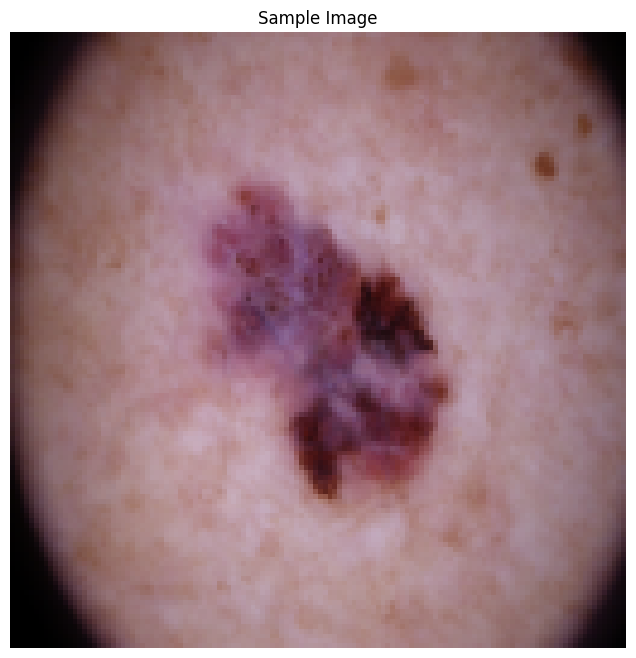

In [ ]:
display_image(images[3])

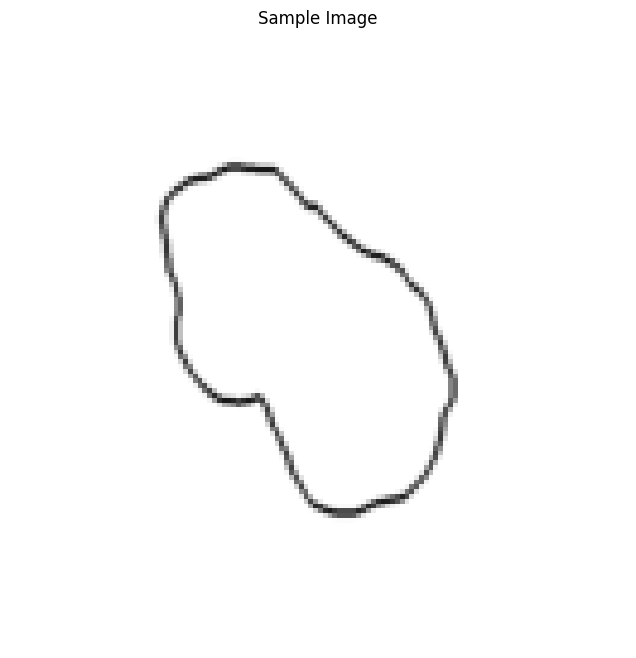

In [ ]:
display_image(sketches[3])

In [ ]:
data_frame = pd.read_csv(TRAIN_DATA_CSV_PATH)
column_names = data_frame.columns.tolist()[1:]
print(column_names)

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


#Grouping data according to labels

In [ ]:
grouped_data = {}
for col in column_list:
    # Check if the column contains the value 1
    if (df[col] == 1).any():
        # Group the DataFrame by the column where the value is 1
        grouped_data[col] = df.loc[df[col] == 1, 'image'].tolist()


In [ ]:
grouped_data['MEL']

#Generating Random Images per Column

In [ ]:
selected_images_by_column = {}
num_images_to_select = 32
for key, image_list in grouped_data.items():
    selected_images = random.sample(image_list, num_images_to_select)
    selected_images_by_column[key] = selected_images


In [ ]:
selected_images_by_column

In [ ]:
transform_img = transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [ ]:
# Create an empty dictionary to store data loaders for each column
loader_dict = {}

# Iterate over each column in the dataset
for col in column_list:
    # Create an empty list to store data tuples (image, label, sketch, class)
    data = []

    # Iterate over randomly selected image names for the current column
    for image_name in selected_images_by_column[col]:
        # Construct the file path for the image
        img_path = TRAIN_IMAGE_DIR + "/" + image_name + '.jpg'
        # Open the image and convert it to RGB format
        img = Image.open(img_path).convert('RGB')

        # Filter the DataFrame to get the label corresponding to the current image
        filtered_df = df[df['image'] == image_name]
        # Extract the label as a tensor
        label = torch.tensor(filtered_df.iloc[:, 1:].values[0], dtype=torch.float32)
        # Determine the class of the image based on the label
        img_class = find_class(np.array(label))

        # Construct the file path for the sketch image
        sketch_path = TRAIN_SKETCH_DIR_PAIRED + '/' + image_name + '_segmentation.png'
        # Open the sketch image and convert it to RGB format
        sketch_img = Image.open(sketch_path).convert('RGB')

        # Apply transformations to the image and sketch image
        img = transform_img(img)
        sketch_img = transform_img(sketch_img)

        # Append the data tuple (image, label, sketch, class) to the list
        data.append((img, label, sketch_img, img_class))

    # Create a data loader for the current column's data
    data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)

    # Add the data loader to the dictionary with the column name as the key
    loader_dict[col] = data_loader


In [ ]:
loader_dict

{'MEL': <torch.utils.data.dataloader.DataLoader at 0x7b82434a07f0>,
 'NV': <torch.utils.data.dataloader.DataLoader at 0x7b82434de500>,
 'BCC': <torch.utils.data.dataloader.DataLoader at 0x7b8243590ee0>,
 'AKIEC': <torch.utils.data.dataloader.DataLoader at 0x7b82432e7b80>,
 'BKL': <torch.utils.data.dataloader.DataLoader at 0x7b82432e78e0>,
 'DF': <torch.utils.data.dataloader.DataLoader at 0x7b8240b7bcd0>,
 'VASC': <torch.utils.data.dataloader.DataLoader at 0x7b82432e7af0>}

In [ ]:
images, labels, sketches, classes = next(iter(loader_dict['MEL']))

In [ ]:
display_image(sketches[15])
display_image(images[15])

In [ ]:
print(images.shape, labels.shape, sketches.shape, classes.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32, 7]) torch.Size([32, 3, 128, 128]) torch.Size([32])


In [ ]:
# wandb.login()
wandb.init(project='DL_assignment4', name='task')

#Discriminator

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, image_channel=10, hidden_dim=8):
        super(Discriminator, self).__init__()

        # Initialize the discriminator blocks as a list of sequential layers
        self.disc_blocks = torch.nn.ModuleList([
            self._discriminator_block(image_channel, hidden_dim),
            self._discriminator_block(hidden_dim, hidden_dim * 2),
            self._discriminator_block(hidden_dim*2, hidden_dim * 4),
            self._discriminator_block(hidden_dim*4, hidden_dim * 6, kernel_size=2, stride=1),
            self._discriminator_block(hidden_dim*6, hidden_dim * 8, kernel_size=2, stride=1),
            self._discriminator_block(hidden_dim * 8, hidden_dim * 16, kernel_size=2, stride=1),
            self._discriminator_block(hidden_dim * 16, hidden_dim * 32, kernel_size=2, stride=1),
            self._discriminator_block(hidden_dim * 32, hidden_dim * 64, kernel_size=2, stride=1),
            self._discriminator_block(hidden_dim * 64, 1, kernel_size=9, stride=1, final_layer=True),
        ])

#         self.embed = torch.nn.Embedding(7, 128*128)

    def _discriminator_block(
        self,
        input_channels,
        output_channels,
        kernel_size=4,
        stride=2,
        final_layer=False,
    ):
        # Define a discriminator block as a sequence of convolutional layers followed by optional normalization and activation
        layers = []
        layers.append(torch.nn.Conv2d(input_channels, output_channels, kernel_size, stride))
        if not final_layer:
            layers.extend([
                torch.nn.BatchNorm2d(output_channels),  # Batch normalization to stabilize training
                torch.nn.LeakyReLU(0.2, inplace=True),  # Leaky ReLU activation for introducing non-linearity
            ])
        return torch.nn.Sequential(*layers)

    def forward(self, x, labels):
        # Concatenate input image with label embedding
        embedding = labels.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 128, 128)
        x = torch.cat([x, embedding], dim=1)

        # Pass through each discriminator block sequentially
        for layer in self.disc_blocks:
            x = layer(x)

        # Flatten the output tensor
        x = x.view(len(x), -1)

        # Apply sigmoid activation to obtain probabilities
        x = torch.sigmoid(x)
        return x


In [ ]:
discriminator = Discriminator().to(DEVICE)
discriminator

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 8, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(2, 2), stride=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0)

In [ ]:
img_from_gen = torch.randn(32, 3, 128, 128).to(DEVICE)
discriminator(img_from_gen, torch.rand(32, 7).to(torch.long).to(DEVICE)).shape

torch.Size([32, 1])

#Generator

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, input_dim=10, image_channel=3, hidden_dim=16):
        super(Generator, self).__init__()
        self.input_dim = input_dim

        self.gen = torch.nn.Sequential(
            self._conv_block(input_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            self._conv_block(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            self._conv_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            self._conv_block(hidden_dim * 4, hidden_dim * 6, kernel_size=4, stride=2, padding=1),
            self._conv_block(hidden_dim * 6, hidden_dim * 8, kernel_size=4, stride=2, padding=1),
        )

        self.upsamp_gen = torch.nn.Sequential(
            self._transpose_conv_block(hidden_dim * 8, hidden_dim * 6, kernel_size=4, stride=2, padding=1),
            self._transpose_conv_block(hidden_dim * 6, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            self._transpose_conv_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            self._transpose_conv_block(hidden_dim * 2, hidden_dim , kernel_size=4, stride=2, padding=1),
            self._transpose_conv_block(hidden_dim, hidden_dim // 2, kernel_size=4, stride=2, padding=1),
            self._transpose_conv_block(hidden_dim // 2, image_channel, kernel_size=3, stride=1, padding=0, final_layer=True),
        )

#         self.embed = torch.nn.Embedding(7, 128*128)

    def _conv_block(
        self,
        input_channels,
        output_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        final_layer=False,
    ):

        if not final_layer:
            return torch.nn.Sequential(
                torch.nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                torch.nn.BatchNorm2d(output_channels),
                torch.nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return torch.nn.Sequential(
                torch.nn.Conv2d(input_channels, output_channels, kernel_size=2, stride=2),
            )

    def _transpose_conv_block(
        self,
        input_channels,
        output_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        final_layer=False,
    ):
        if not final_layer:
            return torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size, stride
                ),
                torch.nn.BatchNorm2d(output_channels),
                torch.nn.ReLU(inplace=True),
            )
        else:
            return torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size, stride
                ),
                torch.nn.Tanh(),
            )

    def forward(self, x, labels):
#         embedding = self.embed(labels).view(labels.shape[0], 7, 128, 128)
        embedding = labels.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 128, 128)
        x = torch.cat([x, embedding], dim=1)
        # x = noise.view(len(noise), self.input_dim, 1, 1)
#         outputs = []
        for layer in self.gen:
#           print("1", x.shape)
          x = layer(x)
#           outputs.append(x)
        for layer in self.upsamp_gen:
            x = layer(x)
        return x

In [ ]:
generator = Generator().to(DEVICE)
generator

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 96, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): 

In [ ]:
latent = torch.randn(32, 3, 128, 128).to(DEVICE)
generator(latent, torch.rand(32, 7).to(torch.long).to(DEVICE)).shape

torch.Size([32, 3, 128, 128])

In [ ]:
criterion = torch.nn.BCELoss()
L1_LOSS = torch.nn.L1Loss()
n_epochs = 100
display_step = 400
lr_gen = 2e-4
lr_dis = 2e-4

In [ ]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_dis, betas=(0.5, 0.999))

In [ ]:
def custom_weights_init(module):
    """
    Custom weight initialization function for neural network modules.

    Args:
        module (torch.nn.Module): Module to initialize weights for.
    """
    if isinstance(module, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        # If the module is a convolutional layer, initialize weights from a normal distribution
        # with mean 0 and standard deviation 0.02
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    elif isinstance(module, torch.nn.BatchNorm2d):
        # If the module is a batch normalization layer, initialize weights from a normal distribution
        # with mean 0 and standard deviation 0.02, and biases with constant value 0
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(module.bias, 0)
    elif isinstance(module, torch.nn.Linear):
        # If the module is a linear layer, initialize weights from a normal distribution
        # with mean 0 and standard deviation 0.02
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            # If the linear layer has biases, initialize them with constant value 0
            torch.nn.init.constant_(module.bias, 0)
    elif isinstance(module, torch.nn.Embedding):
        # If the module is an embedding layer, initialize weights from a normal distribution
        # with mean 0 and standard deviation 0.02
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


In [ ]:

def plot_images_from_tensor(tensor_images, plot_name, num_images=25, image_size=(1, 28, 28), nrow=5, show=True):
    """
    Plot a grid of images from a tensor and log it to Weights & Biases.

    Args:
        tensor_images (torch.Tensor): Tensor containing images.
        plot_name (str): Name of the plot.
        num_images (int, optional): Number of images to plot. Defaults to 25.
        image_size (tuple, optional): Size of each image in the tensor. Defaults to (1, 28, 28).
        nrow (int, optional): Number of images per row in the grid. Defaults to 5.
        show (bool, optional): Whether to show the plot. Defaults to True.
    """
    # Scale the pixel values to the range [0, 1]
    tensor_images = (tensor_images + 1) / 2

    # Detach the tensor from the computational graph and move it to CPU
    image_unflat = tensor_images.detach().cpu()

    # Make a grid of images from the tensor
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)

    # Log the image grid to Weights & Biases
    wandb.log({plot_name: [wandb.Image(image_grid.permute(1, 2, 0).squeeze().cpu().numpy(), caption=plot_name)]})

    # Display the image grid using matplotlib
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

    # Show the plot if requested
    if show:
        plt.show()
